
<h2>Introduction to Time Series Forecasting</h2>

Time series is different from more traditional classification and regression predictive modeling problems. The temporal structure adds an order to the observations. This imposed order means that important assumptions about the consistency of those observations needs to be handled specifically.

The goal of Time Series Forecasting is to make accurate predictions about the future. In this Jupyter Notebook, we will focus on how to make predictions on univariate time series problems using the standard tools in the Python ecosystem. Pandas library in Python provides excellent, built-in support for time series data, while Statsmodels is a Python module that allows users to explore data, estimate statistical models, and perform statistical tests.

Download the Effective Federal Funds Rate dataset from FRED Economic Data website. The federal funds rate is the interest rate at which depository institutions trade federal funds with each other overnight. We will focus on forecasting the interest rates up to the 2008 financial crisis.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
#from pandas import TimeGrouper
#from pandas.tools.plotting import lag_plot
#from pandas.tools.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA



<h2>Data Preparation</h2>


Load and Explore Time Series Data


In [6]:
# load dataset
dataframe = pd.read_csv('AirPassengers.csv',
                       index_col='Month',
                        #dtype={'FEDFUNDS': np.float32},
                        parse_dates=True, 
                        date_parser=lambda date: pd.datetime.strptime(date, '%Y-%m'),
                       )

In [7]:
dataframe.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [8]:
# the index is in datetime format, which is fine
dataframe.index[:5]


DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01'],
              dtype='datetime64[ns]', name='Month', freq=None)

In [9]:
# however, this doesn't look good yet
dataframe.head().values

array([[112],
       [118],
       [132],
       [129],
       [121]])

In [10]:
# unstacking the data might help...
dataframe.unstack().head()

             Month     
#Passengers  1949-01-01    112
             1949-02-01    118
             1949-03-01    132
             1949-04-01    129
             1949-05-01    121
dtype: int64

In [11]:
dataframe.unstack().head().values

array([112, 118, 132, 129, 121])


Create Time Series

Pandas represents time series datasets as a Series. A Series is a one-dimensional array with a time label for each row.


In [12]:
# create a time series
s = pd.Series(dataframe.unstack().values, index=dataframe.index)

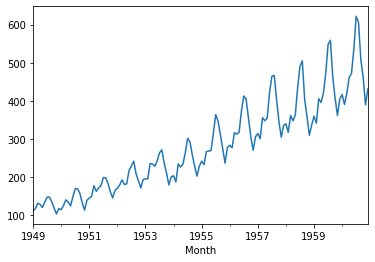

In [13]:
# basic plot
s.plot()

In [14]:
# query a dataset using a date-time index
s[:'2007'].tail(10)


Month
1960-03-01    419
1960-04-01    461
1960-05-01    472
1960-06-01    535
1960-07-01    622
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
dtype: int64

In [15]:
# keep only data before 2008 
s = s[:'2007']


<b>Explore Time Series Data

In [16]:
# display first few lines of a time series
s.head()

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
dtype: int64

In [17]:
s.index[:5]

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01'],
              dtype='datetime64[ns]', name='Month', freq=None)

In [18]:
# display last few lines of a time series
s.tail()

Month
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
dtype: int64

In [19]:
# summarize the dimensions of a time series
s.size

144

In [20]:
# calculate descriptive statistics
s.describe()


count    144.000000
mean     280.298611
std      119.966317
min      104.000000
25%      180.000000
50%      265.500000
75%      360.500000
max      622.000000
dtype: float64

In [21]:
# query a dataset using a date-time index
s['1999-06':'2000-06']

Series([], dtype: int64)


<b>Basic Feature Engineering</b>

Time Series data must be re-framed as a supervised learning dataset before we can start using machine learning algorithms. There is no concept of input and output features in time series. Instead, we must choose the variable to be predicted and use feature engineering to construct all of the inputs that will be used to make predictions for future time steps.

A time series dataset must be transformed to be modeled as a supervised learning problem. We need to transform something that looks like:

time 1, value 1
time 2, value 2
time 3, value 3

into something that looks like:

input 1, output 1
input 2, output 2
input 3, output 3

<b>Date Time Features

The simplest features that we can use are features from the date/time of each observation.


In [22]:
df = pd.DataFrame()
df['year'] = [s.index[i].year for i in range(len(s))]
df['month'] = [s.index[i].month for i in range(len(s))]
df['value'] = s.values.tolist()

In [23]:
df.head()

,year,month,value
0,1949,1,112
1,1949,2,118
2,1949,3,132
3,1949,4,129
4,1949,5,121



<b>Lag Features</b>

Lag features are the classical way that time series forecasting problems are transformed into supervised learning problems. The simplest approach is to predict the value at the next time (t+1) given the value at the current time (t). The supervised learning problem with shifted values looks as follows:

Value(t), Value(t+1)<br>
Value(t), Value(t+1)<br>
Value(t), Value(t+1)<br>



In [24]:
values = pd.DataFrame(s.values)
df = pd.concat([values.shift(1), values], axis=1)
df.columns = ['t', 't+1']


In [25]:
df.head()

,t,t+1
0,NaN,112
1,112.0,118
2,118.0,132
3,132.0,129
4,129.0,121


In [26]:
df.tail()

,t,t+1
139,622.0,606
140,606.0,508
141,508.0,461
142,461.0,390
143,390.0,432



<h2>WIndow Features</h2>

The addition of lag features is called the sliding window method, in this case with a window width of 1. It is as though we are sliding our focus along the time series for each observation with an interest in only what is within the window width. We can expand the window width and include more lagged features.


In [27]:
values = pd.DataFrame(s.values)
df = pd.concat([values.shift(3), values.shift(2), values.shift(1), values], axis=1)
df.columns = ['t-2', 't-1', 't', 't+1']

In [28]:
df.head()



,t-2,t-1,t,t+1
0,NaN,NaN,NaN,112
1,NaN,NaN,112.0,118
2,NaN,112.0,118.0,132
3,112.0,118.0,132.0,129
4,118.0,132.0,129.0,121



<h4>Rolling Window Statistics</h4>

A step beyond adding raw lagged values is to add a summary of the values at previous time steps. We can calculate summary statistics across the values in the sliding window and include these as features in our dataset. Perhaps the most useful is the mean of the previous values, also called the rolling mean.


In [29]:
values = pd.DataFrame(s.values)
shifted = values.shift(1)
window = shifted.rolling(window=2)
means = window.mean()

df = pd.concat([means, values], axis=1)
df.columns = ['mean(t-1,t)', 't+1']

In [30]:
df.head()

,"mean(t-1,t)",t+1
0,NaN,112
1,NaN,118
2,115.0,132
3,125.0,129
4,130.5,121


In [31]:
values = pd.DataFrame(s.values)
width = 3
shifted = values.shift(width - 1)
window = shifted.rolling(window=width)

df = pd.concat([window.min(), window.mean(), window.max(), values], axis=1)
df.columns = ['min', 'mean', 'max', 't+1']


In [32]:
df.head()

,min,mean,max,t+1
0,NaN,NaN,NaN,112
1,NaN,NaN,NaN,118
2,NaN,NaN,NaN,132
3,NaN,NaN,NaN,129
4,112.0,120.666667,132.0,121



<h4>Expanding Window Statistics</h4>

Another type of window that may be useful includes all previous data in the series. This is called an expanding window and can help with keeping track of the bounds of observable data.


In [33]:
values = pd.DataFrame(s.values)
window = values.expanding()

df = pd.concat([window.min(), window.mean(), window.max(), values], axis=1)
df.columns = ['min', 'mean', 'max', 't+1']


In [34]:
df.head()

,min,mean,max,t+1
0,112.0,112.000000,112.0,112
1,112.0,115.000000,118.0,118
2,112.0,120.666667,132.0,132
3,112.0,122.750000,132.0,129
4,112.0,122.400000,132.0,121



<h4>Data Visualization</h4>

Time series lends itself naturally to visualization. Line plots of observations over time are popular, but there is a suite of other plots that you can use to learn more about your problem. The more you learn about your data, the more likely you are to develop a better forecasting model.
Line Plot

Perhaps the most popular visualization for time series is the line plot. In this plot, time is shown on the x-axis with observation values along the y-axis.


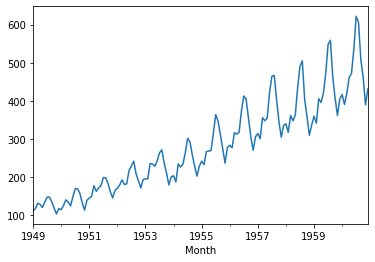

In [35]:
s.plot()

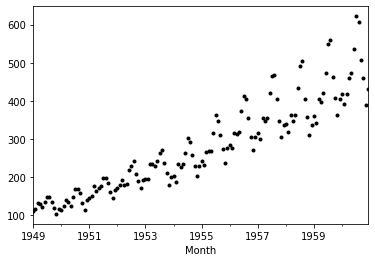

In [36]:
s.plot(style='k.')


<h4>Histogram and Density Plots</h4>

Another important visualization is of the distribution of observations themselves. This means a plot of the values without the temporal ordering. Some linear time series forecasting methods assume a well-behaved distribution of observations (i.e. a bell curve or normal distribution). This can be explicitly checked using tools like statistical hypothesis tests. But plots can provide a useful first check of the distribution of observations both on raw observations and after any type of data transform has been performed.


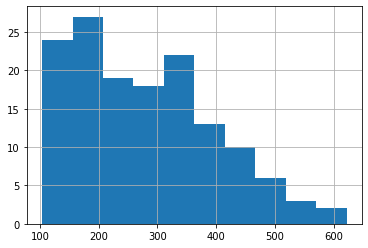

In [37]:
s.hist()

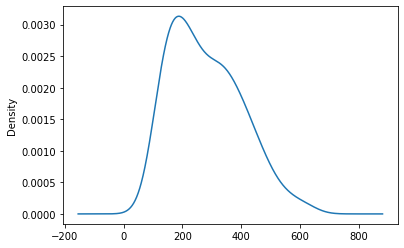

In [38]:
s.plot(kind='kde')


<h4>Box and Whisker Plots</h4>

Histograms and density plots provide insight into the distribution of all observations, but we may be interested in the distribution of values by time interval. Another type of plot that is useful to summarize the distribution of observations is the box and whisker plot. This plot draws a box around the 25th and 75th percentiles of the data that captures the middle 50% of observations. A line is drawn at the 50th percentile (the median) and whiskers are drawn above and below the box to summarize the general extents of the observations. Dots are drawn for outliers outside the whiskers or extents of the data.


In [39]:
years, index = [], []
for name, gr in s.groupby(TimeGrouper('A')):
    years.append(gr.values)
    index.append(name.year)
df = pd.DataFrame(years, index=index, columns=range(1,13))

NameError: name 'TimeGrouper' is not defined

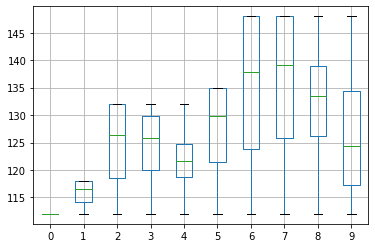

In [40]:
df.head(10).T.boxplot()


Comparing box and whisker plots by consistent intervals is a useful tool. Within an interval, it can help to spot outliers (dots above or below the whiskers). Across intervals, in this case years, we can look for multiple year trends, seasonality, and other structural information that could be modeled.

<h4>Heat Maps

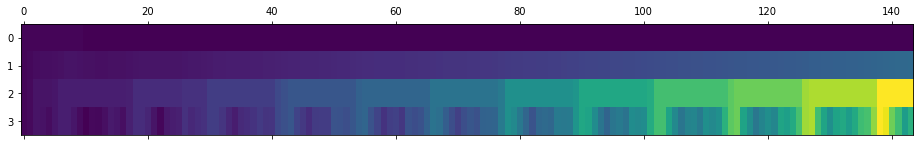

In [41]:
plt.matshow(df.T, interpolation=None, aspect='auto')

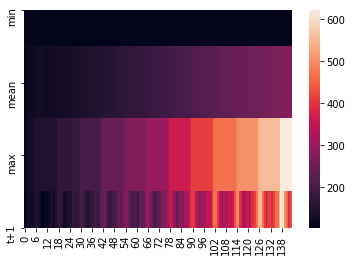

In [42]:
sns.heatmap(df.T)


<h4>Lag Scatter Plots</h4>

Time series modeling assumes a relationship between an observation and the previous observation. Previous observations in a time series are called lags, with the observation at the previous time step called lag=1, the observation at two time steps ago lag=2, and so on. A useful type of plot to explore the relationship between each observation and a lag of that observation is called the scatter plot. Pandas has a built-in function for exactly this called the lag plot. It plots the observation at time t on the x-axis and the lag=1 observation (t-1) on the y-axis.

    If the points cluster along a diagonal line from the bottom-left to the top-right of the plot, it suggests a positive correlation relationship.
    If the points cluster along a diagonal line from the top-left to the bottom-right, it suggests a negative correlation relationship.
    Either relationship is good as they can be modeled.

More points tighter in to the diagonal line suggests a stronger relationship and more spread from the line suggests a weaker relationship. A ball in the middle or a spread across the plot suggests a weak or no relationship.


In [43]:
# create a scatter plot
lag_plot(s)

NameError: name 'lag_plot' is not defined

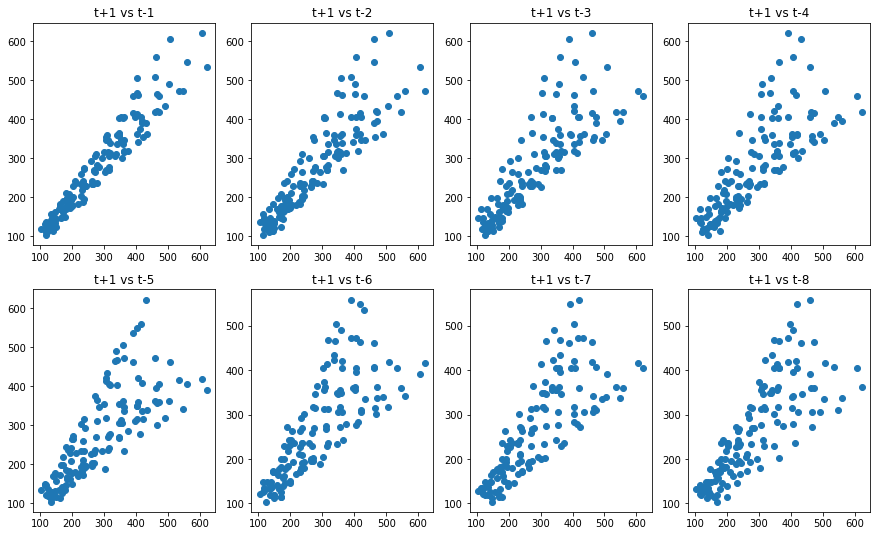

In [44]:
# create multiple scatter plots
values = pd.DataFrame(s.values)
lags = 8
columns = [values]

for i in range(1,(lags + 1)):
    columns.append(values.shift(i))

df = pd.concat(columns, axis=1)
columns = ['t+1']

for i in range(1,(lags + 1)):
    columns.append('t-' + str(i))
df.columns = columns

plt.figure(1, figsize=(15,9))
for i in range(1,(lags + 1)):
    ax = plt.subplot(240 + i)
    ax.set_title('t+1 vs t-' + str(i))
    plt.scatter(x=df['t+1'].values, y=df['t-'+str(i)].values)



<h4>Autocorrelation Plots</h4>

We can quantify the strength and type of relationship between observations and their lags. In statistics, this is called correlation, and when calculated against lag values in time series, it is called autocorrelation (self-correlation). A correlation value calculated between two groups of numbers, such as observations and their lag=1 values, results in a number between -1 and 1. The sign of this number indicates a negative or positive correlation respectively. A value close to zero suggests a weak correlation, whereas a value closer to -1 or 1 indicates a strong correlation.

Correlation values, called correlation coeficients, can be calculated for each observation and different lag values. Once calculated, a plot can be created to help better understand how this relationship changes over the lag. This type of plot is called an autocorrelation plot.


In [45]:
# create an autocorrelation plot
autocorrelation_plot(s)

NameError: name 'autocorrelation_plot' is not defined

The Statsmodels library also provides a version of the autocorrelation plot as a line plot. Plots lags on the horizontal and the correlations on vertical axis.

In [ ]:
# autocorrelation plot of time series as a line plot
plot_acf(s, lags=50)
plt.show()

In [ ]:
# create an autocorrelation plot, using only the last 100 entries
autocorrelation_plot(s[-100:])

In [ ]:


# autocorrelation plot of time series as a line plot
plot_acf(s[-100:], lags=50)
plt.show()




<h4>Moving Average Smoothing</h4>

Moving average smoothing is a naive and effective technique in time series forecasting. It can be used for data preparation, feature engineering, and even directly for making predictions. Smoothing is a technique applied to time series to remove the fine-grained variation between time steps. The hope of smoothing is to remove noise and better expose the signal of the underlying causal processes.


In [ ]:
# tail-rolling average transform
rolling = s.rolling(window=3)
rolling_mean = rolling.mean()

In [ ]:
rolling_mean.head(10)

NameError: name 'rolling_mean' is not defined

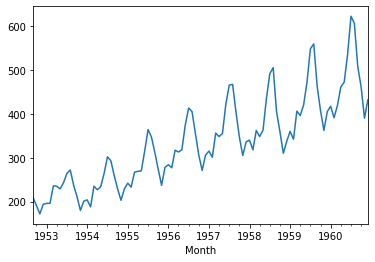

In [46]:
# plot original and transformed dataset
s[-100:].plot()
rolling_mean[-100:].plot(color='red')


<h4>Moving Average as Prediction</h4>

The moving average value can also be used directly to make predictions. It is a naive model and assumes that the trend and seasonality components of the time series have already been removed or adjusted for. The moving average model for predictions can easily be used in a walk-forward manner. As new observations are made available (e.g. daily), the model can be updated and a prediction made for the next day.


In [47]:
# prepare problem
X = s.values
window = 3
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = []

# walk forward over time steps in test
for t in range(len(test)):
    length = len(history)
    yhat = np.mean([history[i] for i in range(length-window,length)])
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
rmse = np.sqrt(mean_squared_error(test, predictions))

In [48]:
print('RMSE: %.3f' % rmse)

RMSE: 48.370


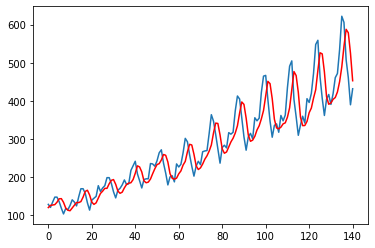

In [49]:
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

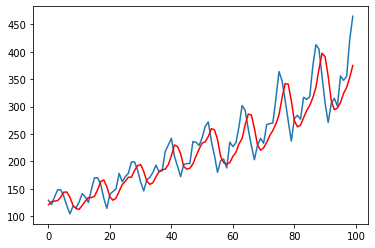

In [50]:
# zoom plot
plt.plot(test[:100])
plt.plot(predictions[:100], color='red')
plt.show()


<h4>Time Series Components</h4>

A useful abstraction for selecting forecasting methods is to break a time series down into systematic and unsystematic components.

    Systematic: Components of the time series that have consistency or recurrence and can be described and modeled.
    Non-Systematic: Components of the time series that cannot be directly modeled.

A given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise. These components are defined as follows:

    Level: The average value in the series.
    Trend: The increasing or decreasing value in the series.
    Seasonality: The repeating short-term cycle in the series.
    Noise: The random variation in the series.

Our time series dataset may contain a trend. A trend is a continued increase or decrease in the series over time. There can be benefit in identifying, modeling, and even removing trend information from your time series dataset.

Time series datasets can contain a seasonal component. This is a cycle that repeats over time, such as monthly or yearly. This repeating cycle may obscure the signal that we wish to model when forecasting, and in turn may provide a strong signal to our predictive models. There are many types of seasonality: time of day, daily, weekly, monthly, yearly etc. Identifying whether there is a seasonality component in your time series problem is subjective. The simplest approach to determining if there is an aspect of seasonality is to plot and review your data, perhaps at different scales and with the addition of trend lines.

A time series where the seasonal component has been removed is called seasonal stationary. If a dataset does not have a trend or we successfully remove the trend, the dataset is said to be trend stationary.
Stationarity in Time Series Data

The observations in a stationary time series are not dependent on time. Time series are stationary if they do not have trend or seasonal effects. Summary statistics calculated on the time series are consistent over time, like the mean or the variance of the observations. When a time series is stationary, it can be easier to model. Statistical modeling methods assume or require the time series to be stationary to be effective.
Check for Stationarity

There are many methods to check whether a time series (direct observations, residuals, otherwise) is stationary or non-stationary.

    Look at Plots: You can review a time series plot of your data and visually check if there are any obvious trends or seasonality.
    Summary Statistics: You can review the summary statistics for your data for seasons or random partitions and check for obvious or significant differences.
    Statistical Tests: You can use statistical tests to check if the expectations of stationarity are met or have been violated.



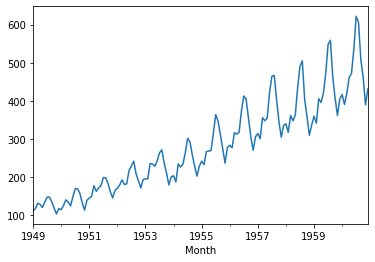

In [51]:
s.plot()


<h4>Augmented Dickey-Fuller test</h4>

The Augmented Dickey-Fuller test is a type of statistical test called a unit root test. The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend. It uses an autoregressive model and optimizes an information criterion across multiple different lag values. The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.


In [52]:
# calculate stationarity test of time series data
X = s.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.815369
p-value: 0.991880
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579




We can see that our statistic value of -3.185 is less than the value of -2.866 at 5%. This suggests that we can reject the null hypothesis with a significance level of less than 5% (i.e. a low probability that the result is a statistical fluke). Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.
Evaluate Models

The goal of time series forecasting is to make accurate predictions about the future. The fast and powerful methods that we rely on in machine learning, such as using train-test splits and k-fold cross-validation, do not work in the case of time series data. This is because they ignore the temporal components inherent in the problem.

In time series forecasting, this evaluation of models on historical data is called backtesting. We will look at three different methods that you can use to backtest your machine learning models on time series problems:

    1.Train-Test split that respects temporal order of observations.
    2.Multiple Train-Test splits that respect temporal order of observations.
    3.Walk-Forward Validation where a model may be updated each time step new data is received.




<h4>Train-Test Split

In [53]:
# calculate a train-test split of a time series dataset
X = s.values
train_size = int(len(X) * 0.66)
train, test = X[0:train_size], X[train_size:len(X)]

In [54]:
print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))


Observations: 144
Training Observations: 95
Testing Observations: 49


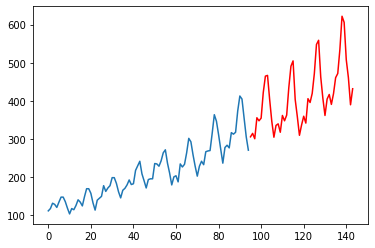

In [55]:
# plot train-test split of time series data
plt.plot(train)
plt.plot([None for i in train] + [x for x in test], color='r')


<h4>Multiple Train-Test Splits</h4>

We can repeat the process of splitting the time series into train and test sets multiple times. This will require multiple models to be trained and evaluated, but this additional computational expense will provide a more robust estimate of the expected performance of the chosen method and configuration on unseen data. We could do this manually by repeating the train-split tests with different split points.

The scikit-learn library provides a time series "cross-validator" in the TimeSeriesSplit module. It provides train/test indices to split time series data samples that are observed at fixed time intervals, in train/test sets. Note that unlike standard cross-validation methods, successive training sets are supersets of those that come before them.


Observations: 72
Training Observations: 36
Testing Observations: 36
-----
Observations: 108
Training Observations: 72
Testing Observations: 36
-----
Observations: 144
Training Observations: 108
Testing Observations: 36
-----


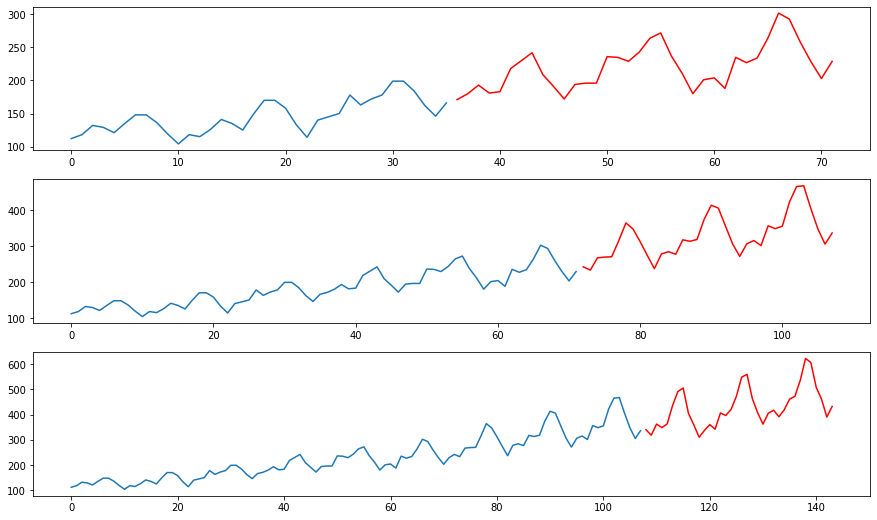

In [56]:
# calculate repeated train-test splits of time series data
X = s.values
splits = TimeSeriesSplit(n_splits=3)
index = 1
plt.figure(1, figsize=(15,9))

for train_index, test_index in splits.split(X):
    train = X[train_index]
    test = X[test_index]

    print('Observations: %d' % (len(train) + len(test)))
    print('Training Observations: %d' % (len(train)))
    print('Testing Observations: %d\n-----' % (len(test)))

    plt.subplot(310 + index)
    plt.plot(train)
    plt.plot([None for i in train] + [x for x in test], color='r')
    index += 1
plt.show() 




Using multiple train-test splits will result in more models being trained, and in turn, a more accurate estimate of the performance of the models on unseen data. A limitation of the train-test split approach is that the trained models remain fixed as they are evaluated on each evaluation in the test set. This may not be realistic as models can be retrained as new daily or monthly observations are made available.
Walk Forward Validation

In practice, we very likely will retrain our model as new data becomes available. This would give the model the best opportunity to make good forecasts at each time step.

There are few decisions to make:

    1.Minimum Number of Observations. First, we must select the minimum number of observations required to train the model. This may be thought of as the window width if a sliding window is used (see next point).
   2. Sliding or Expanding Window. Next, we need to decide whether the model will be trained on all data it has available or only on the most recent observations. This determines whether a sliding or expanding window will be used.



In [57]:
# walk forward validation: the train set expanding each time step and the test set fixed at one time step ahead
X = s[-100:].values
n_train = 80
n_records = len(X)

for i in range(n_train, n_records):
    train, test = X[0:i], X[i:i+1]
    print('train=%d, test=%d' % (len(train), len(test)))

train=80, test=1
train=81, test=1
train=82, test=1
train=83, test=1
train=84, test=1
train=85, test=1
train=86, test=1
train=87, test=1
train=88, test=1
train=89, test=1
train=90, test=1
train=91, test=1
train=92, test=1
train=93, test=1
train=94, test=1
train=95, test=1
train=96, test=1
train=97, test=1
train=98, test=1
train=99, test=1



Persistence Model for Forecasting

Establishing a baseline is essential on any time series forecasting problem. A baseline in performance gives you an idea of how well all other models will actually perform on your problem. Here we will develop a persistence forecast that we can use later as a baseline level of performance on this time series dataset.

The following steps are required:

   1. Transform the univariate dataset into a supervised learning problem.
   2. Establish the train and test datasets for the test harness.
   3. Define the persistence model.
   4. Make a forecast and establish a baseline performance.
    5.Review the complete example and plot the output.



In [58]:
# Create lagged dataset
values = pd.DataFrame(s.values)
df = pd.concat([values.shift(1), values], axis=1)
df.columns = ['t', 't+1']

In [59]:
# split into train and test sets
X = df.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]

train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

In [60]:
# persistence model
def model_persistence(x):
    return x

In [61]:
# walk-forward validation
predictions = []
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
rmse = np.sqrt(mean_squared_error(test_y, predictions))

In [62]:
print('Test RMSE: %.3f' % rmse)

Test RMSE: 47.811


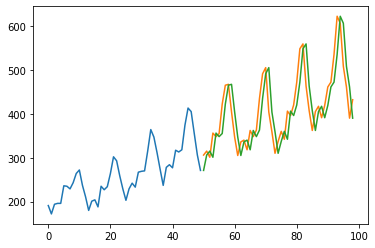

In [63]:
# plot predictions and expected results on the test data
plt.plot(train_y[-50:])
plt.plot([None for i in train_y[-50:]] + [x for x in test_y])
plt.plot([None for i in train_y[-50:]] + [x for x in predictions])


<h4>Visualize Residual Forecast Errors</h4>

Forecast errors on a time series forecasting problem are called residual errors or residuals. A residual error is calculated as the expected outcome minus the forecast. Careful exploration of residual errors on your time series prediction problem can tell you a lot about your forecast model and even suggest improvements.


In [64]:
# calculate residuals from the above persistence model
residuals = [test_y[i]-predictions[i] for i in range(len(predictions))]
residuals = pd.DataFrame(residuals)


The first plot is to look at the residual forecast errors over time as a line plot. We would expect the plot to be random around the value of 0 and not show any trend or cyclic structure.

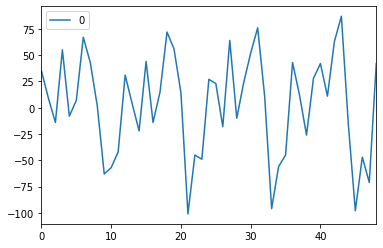

In [65]:
# plot residuals
residuals.plot()


We can calculate summary statistics on the residual errors. Primarily, we are interested in the mean value of the residual errors. A value close to zero suggests no bias in the forecasts, whereas positive and negative values suggest a positive or negative bias in the forecasts made. It is useful to know about a bias in the forecasts as it can be directly corrected in forecasts prior to their use or evaluation.

In [66]:
residuals.describe()

,0
count,49.000000
mean,3.285714
std,48.191891
min,-101.000000
25%,-26.000000
50%,11.000000
75%,42.000000
max,87.000000


Plots can be used to better understand the distribution of errors beyond summary statistics. We would expect the forecast errors to be normally distributed around a zero mean.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff2923f8cf8>]],
      dtype=object)

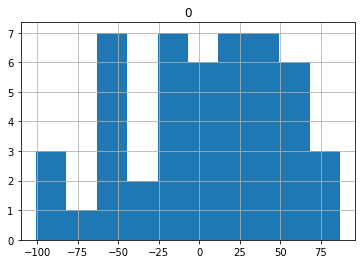

In [67]:
# histograms plot
residuals.hist()


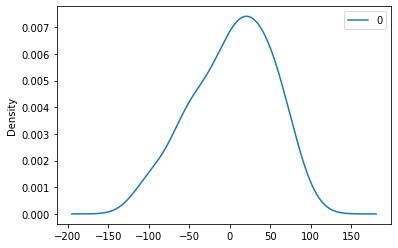

In [68]:
# density plot
residuals.plot(kind='kde')


<h4>Residual Q-Q Plot</h4>

A Q-Q plot, or quantile plot, compares two distributions and can be used to see how similar or different they happen to be. The Q-Q plot can be used to quickly check the normality of the distribution of residual errors. The values are ordered and compared to an idealized Gaussian distribution. The comparison is shown as a scatter plot (theoretical on the x-axis and observed on the y-axis) where a match between the two distributions is shown as a diagonal line from the bottom left to the top-right of the plot.


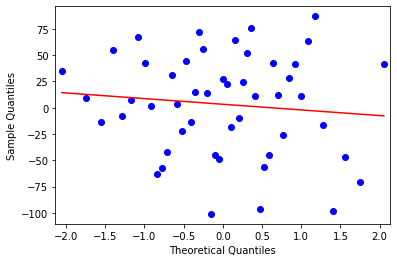

In [69]:
qqplot(residuals, line='r')
plt.show()



<h4>Residual Autocorrelation Plot</h4>

We would not expect there to be any correlation between the residuals. This would be shown by autocorrelation scores being below the threshold of significance (dashed and dotted horizontal lines on the plot). A significant autocorrelation in the residual plot suggests that the model could be doing a better job of incorporating the relationship between observations and lagged observations, called autoregression.


In [70]:
autocorrelation_plot(residuals)

NameError: name 'autocorrelation_plot' is not defined

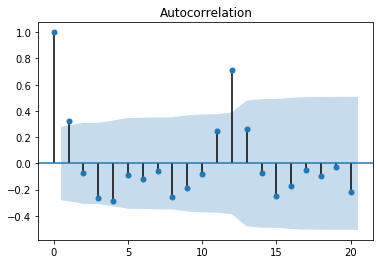

In [71]:
# autocorrelation plot of residuals as a line plot
plot_acf(residuals, lags=20)
plt.show()


<h4><b>Reframe Time Series Forecasting Problems</b></h4>

There are many ways to reframe the forecast problem that can both simplify the prediction problem and potentially expose more or different information to be modeled. A reframing can ultimately result in better and/or more robust forecasts.
<h4>Classification Framings</h4>

Classification involves predicting categorical or label outputs (such as high, medium, and low). For example, we can forecast whether a change in minimum value will be small or large, or whether the new value will be lower or higher than the current value.


In [72]:
# Create lagged dataset
values = pd.DataFrame(s.values)
df = pd.concat([values.shift(1), values], axis=1)
df.columns = ['t', 't+1']


In [73]:
def make_discrete(row):
   if row['t+1'] < 0:
      return 'low'
   elif row['t+1'] > 3:
      return 'high'
   else:
      return 'medium'

In [74]:
# apply the above function to reassign t+1 values
df['t+1'] = df.apply(lambda row: make_discrete(row), axis=1)

In [75]:
# Randomly sample 10 elements from the dataframe
df.sample(n=10)

,t,t+1
115,491.0,high
138,535.0,high
23,114.0,high
68,293.0,high
108,336.0,high
25,145.0,high
121,360.0,high
93,355.0,high
97,315.0,high
63,235.0,high



Time Horizon Framings

    > Forecast the minimum value for the next 3 months.
    > Forecast the maximum value relative to the average from the past 12 months.
    > Forecast the month in the next year that will have the lowest value.

In [76]:
# create lagged dataset
values = pd.DataFrame(s.values)
df = pd.concat([values.shift(1), values, values.shift(-1), values.shift(-2)], axis=1)
df.columns = ['t', 't+1', 't+2', 't+3']

In [77]:
df.head()

,t,t+1,t+2,t+3
0,NaN,112,118.0,132.0
1,112.0,118,132.0,129.0
2,118.0,132,129.0,121.0
3,132.0,129,121.0,135.0
4,129.0,121,135.0,148.0


We can now define the problem as: given the minimum interest rate from the day before, forecast the minimum value for the next 3 days.


<h4>Forecasting</h4>

We chose Persistence Model as our forecast performance baseline, and obtained the root mean squared error of RMSE=0.187. We would now like to improve this result.

<h4>Autoregression Model</h4>

Autoregression is a time series model that uses observations from previous time steps as input to a regression equation to predict the value at the next time step. It is a very simple idea that can result in accurate forecasts on a range of time series problems.


In [78]:
# split dataset
X = s.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]

An autoregression model makes an assumption that the observations at current and previous time steps are useful to predict the value at the next time step. This relationship between variables is called correlation. If both variables change in the same direction, this is called a positive correlation. If the variables move in opposite directions as values change (e.g. one goes up and one goes down), then this is called negative correlation.

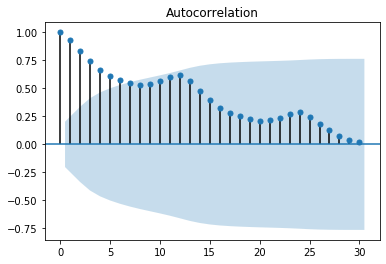

In [79]:
plot_acf(train, lags=30)
plt.show()

An autoregression model is a linear regression model that uses lagged variables as input variables. The Statsmodels library provides an autoregression model that automatically selects an appropriate lag value using statistical tests and trains a linear regression model. It is provided in the AR class.

In [80]:
# train autoregression
model = AR(train)
model_fit = model.fit()

In [81]:
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

Lag: 12
Coefficients: [ 0.59140795  0.48803259 -0.25522017  0.17089236 -0.21099252  0.21241271
 -0.11387109  0.09605027 -0.21578348  0.22833585 -0.1966301   0.31994813
  0.57585993]


<b>Use the Model to Make Predictions for One Week</b>

In [82]:
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

In [83]:
test_period = 7
for i in range(test_period):
    print('predicted=%f, expected=%f' % (predictions[i], test[i]))

rmse = np.sqrt(mean_squared_error(test[:test_period], predictions[:test_period]))

predicted=306.978357, expected=306.000000
predicted=326.242172, expected=315.000000
predicted=323.466064, expected=301.000000
predicted=350.387519, expected=356.000000
predicted=352.194565, expected=348.000000
predicted=370.678221, expected=355.000000
predicted=426.513059, expected=422.000000


In [84]:
print('Test RMSE: %.3f' % rmse)

Test RMSE: 11.633


This is significantly worse than persistence model! What could be a possible reason?

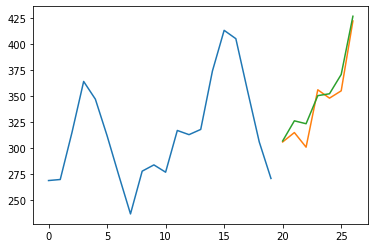

In [85]:
# plot predictions and expected results on the test data
plt.plot(train_y[-20:])
plt.plot([None for i in train_y[-20:]] + [x for x in test_y[:test_period]])
plt.plot([None for i in train_y[-20:]] + [x for x in predictions[:test_period]])



Obviously, we want to rebuild the model after each day as the new data becomes available.<br>
<h4>
<b>Walk Forward Validation</b></h4>

The Statsmodels API does not make it easy to update the model as new observations become available. One way would be to re-train the AR model each day as new observations become available, and that may be a valid approach, if not computationally expensive. An alternative would be to use the learned coeficients and manually make predictions. This requires that the history of prior observations be kept and that the coeficients be retrieved from the model and used in the regression equation to come up with new forecasts.


In [86]:
# split dataset
X = s.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]

In [87]:
# train autoregression
model = AR(train)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params

In [88]:
# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = []
for t in range(len(test)):
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
rmse = np.sqrt(mean_squared_error(test, predictions))

In [89]:
print('Test RMSE: %.3f' % rmse)

Test RMSE: 20.367


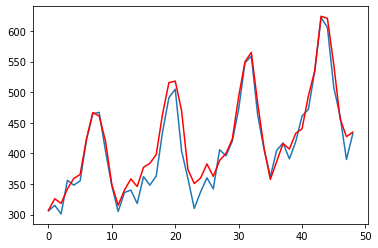

In [90]:
# plot
plt.plot(test)
plt.plot(predictions, color='red')

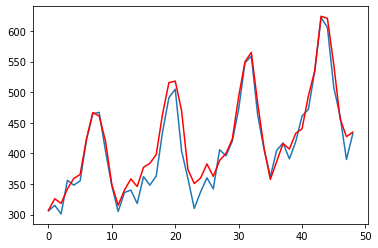

In [91]:
# zoom plot
plt.plot(test[-100:])
plt.plot(predictions[-100:], color='red')
plt.show()


<h4>Persistence Forecast Model</h4>

Let's review the results of the Persistence Model.


In [92]:
# create lagged dataset
values = pd.DataFrame(s.values)
df = pd.concat([values.shift(1), values], axis=1)
df.columns = ['t', 't+1']


In [93]:
# split into train and test sets
X = df.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

In [94]:
# persistence model
predictions = [x for x in test_X]

In [95]:
# skill of persistence model
rmse = np.sqrt(mean_squared_error(test_y, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 47.811


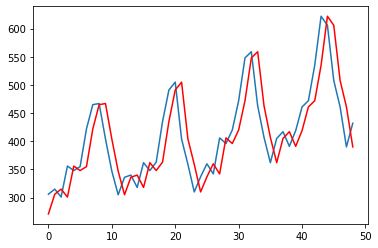

In [96]:
# plot
plt.plot(test_y)
plt.plot(predictions, color='red')

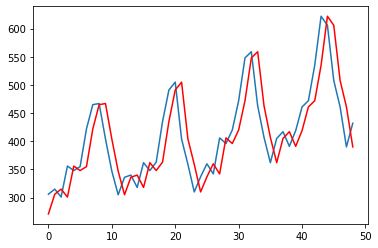

In [97]:
# zoom plot
plt.plot(test_y[-100:])
plt.plot(predictions[-100:], color='red')
plt.show()


<h4> Average Models for Forecasting</h4>

The dierence between what was expected and what was predicted is called the residual error. The residual errors from forecasts on a time series provide another source of information that we can model. Residual errors themselves form a time series that can have temporal structure. A simple autoregression model of this structure can be used to predict the forecast error, which in turn can be used to correct forecasts. This type of model is called a moving average model, the same name but very different from moving average smoothing.<br>

<h4>Autoregression of Residual Error</h4>

We can model the residual error time series using an autoregression model. This is a linear regression model that creates a weighted linear sum of lagged residual error terms.

We can use the autoregression model (AR) provided by the Statsmodels library. Building on the persistence model (see the previous section), we can first train the model on the residual errors calculated on the training dataset.


In [98]:
# create lagged dataset
values = pd.DataFrame(s.values)
df = pd.concat([values.shift(1), values], axis=1)
df.columns = ['t', 't+1']

In [99]:
# split into train and test sets
X = df.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]


In [100]:
# persistence model on training set
train_pred = [x for x in train_X]

In [101]:
# calculate residuals
train_resid = [train_y[i]-train_pred[i] for i in range(len(train_pred))]

In [102]:
# model the training set residuals
model = AR(train_resid)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params

In [103]:
print('Lag=%d, Coef=%s' % (window, coef))

Lag=12, Coef=[ 6.73096433 -0.15858052 -0.24789727 -0.19155056 -0.26996064 -0.17048485
 -0.23497743 -0.21772851 -0.30489576 -0.18296949 -0.30251053 -0.11015227
  0.74668214]




The autoregression model requires the residual error of the 17 previous time steps. Therefore, we must keep these values handy. As we step through the test dataset timestep by timestep making predictions and estimating error, we can then calculate the actual residual error and update the residual error time series lag values (history) so that we can calculate the error at the next time step.


In [104]:
# walk forward over time steps in test
history = train_resid[len(train_resid)-window:]
history = [history[i] for i in range(len(history))]
predictions, expected_error = [], []

for t in range(len(test_y)):
    # persistence
    yhat = test_X[t]
    error = test_y[t] - yhat
    expected_error.append(error)

    # predict error
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    pred_error = coef[0]

    for d in range(window):
        pred_error += coef[d+1] * lag[window-d-1]
    predictions.append(pred_error)
    history.append(error)
    #print('predicted error=%f, expected error=%f' % (pred_error, error))

This is a walk forward forecast, or a rolling forecast, model. We end up with a time series of the residual forecast error from the train dataset and a predicted residual error on the test dataset. We can plot these and get a quick idea of how skillful the model is at predicting residual error.

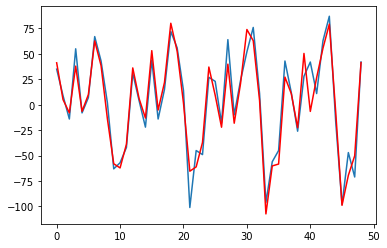

In [105]:
# plot predicted error
plt.plot(expected_error)
plt.plot(predictions, color='red')
plt.show()



Correct Predictions with a Model of Residuals

A model of forecast residual error is interesting, but it can also be useful to make better predictions. With a good estimate of forecast error at a time step, we can make better predictions. For example, we can add the expected forecast error to a prediction to correct it and in turn improve the skill of the model.


In [106]:
# create lagged dataset
values = pd.DataFrame(s.values)
df = pd.concat([values.shift(1), values], axis=1)
df.columns = ['t', 't+1']


In [107]:
# split into train and test sets
X = df.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

In [108]:
# persistence model on training set
train_pred = [x for x in train_X]

In [109]:
# calculate residuals
train_resid = [train_y[i]-train_pred[i] for i in range(len(train_pred))]

In [110]:
# model the training set residuals
model = AR(train_resid)
model_fit = model.fit()

window = model_fit.k_ar
coef = model_fit.params

In [111]:
# walk forward over time steps in test
history = train_resid[len(train_resid)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()

for t in range(len(test_y)):
    # persistence
    yhat = test_X[t]
    error = test_y[t] - yhat

    # predict error
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    pred_error = coef[0]
    for d in range(window):
        pred_error += coef[d+1] * lag[window-d-1]

    # correct the prediction
    yhat = yhat + pred_error
    predictions.append(yhat)
    history.append(error)
    #print('predicted=%f, expected=%f' % (yhat, test_y[t]))

# error
rmse = np.sqrt(mean_squared_error(test_y, predictions))

In [112]:
print('Test RMSE: %.3f' % rmse)

Test RMSE: 13.897


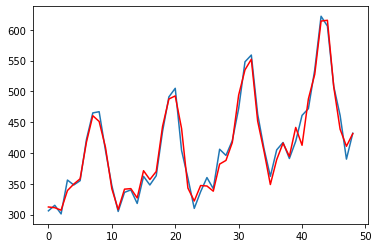

In [113]:
# plot predicted error
plt.plot(test_y)
plt.plot(predictions, color='red')

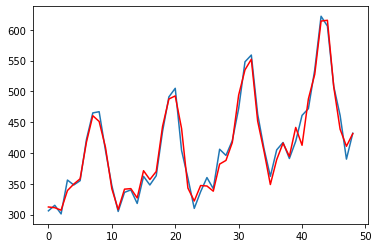

In [114]:
# zoom plot
plt.plot(test_y[-100:])
plt.plot(predictions[-100:], color='red')
plt.show()


<h4>ARIMA Model for Forecasting</h4>

The Autoregressive Integrated Moving Average Model, or ARIMA for short is a standard statistical model for time series forecast and analysis. An ARIMA model is a class of statistical model for analyzing and forecasting time series data.

ARIMA is an acronym that stands for Autoregressive Integrated Moving Average Model. This acronym is descriptive, capturing the key aspects of the model itself:
    <ul>

   AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.<br>
    I: Integrated. The use of differencing of raw observations (i.e. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.<br>
    MA: Moving Average. A model that uses the dependency between an observation and residual errors from a moving average model applied to lagged observations.
    </ul>

The parameters of the ARIMA model are defined as follows:

    p: The number of lag observations included in the model, also called the lag order.
    d: The number of times that the raw observations are differenced, also called the degree of differencing.
    q: The size of the moving average window, also called the order of moving average.

Let's start off with something simple. We will fit an ARIMA model to the entire Shampoo Sales dataset and review the residual errors. First, we fit an ARIMA(5,1,0) model. This sets the lag value to 5 for autoregression, uses a difference order of 1 to make the time series stationary, and uses a moving average model of 0.


In [115]:
# fit model
model = ARIMA(s, order=(5,1,0))
model_fit = model.fit(disp=0)

/home/ritu/my_project_dir/my_project_env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/ritu/my_project_dir/my_project_env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [116]:


# summary of fit model
print(model_fit.summary())



                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  143
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -688.248
Method:                       css-mle   S.D. of innovations             29.720
Date:                Fri, 04 Oct 2019   AIC                           1390.495
Time:                        16:05:59   BIC                           1411.235
Sample:                    02-01-1949   HQIC                          1398.923
                         - 12-01-1960                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6402      2.016      1.310      0.193      -1.311       6.592
ar.L1.D.y      0.3120      0.084      3.715      0.000       0.147       0.477
ar.L2.D.y     -0.2226      0.087     -2.544      0.0

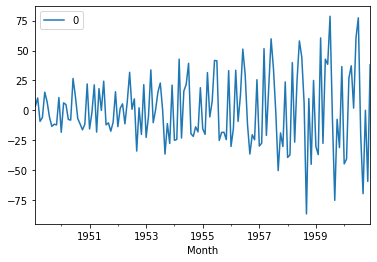

In [117]:
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

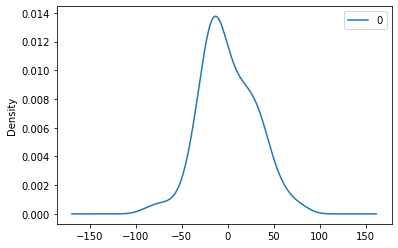

In [118]:
# density plot of residuals
residuals.plot(kind='kde')


[(-2, 2)]

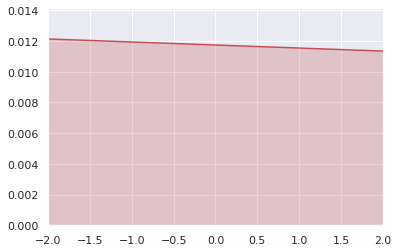

In [119]:
# density plot of residuals, using Seaborn kdeplot
sns.set(color_codes=True)
sns.kdeplot(np.hstack(residuals.values), shade=True, color="r").set(xlim=(-2, 2))

In [121]:
# summary stats of residuals
residuals.describe()

,0
count,143.000000
mean,0.010278
std,29.828334
min,-86.805628
25%,-19.916197
50%,-5.624244
75%,21.573882
max,78.697534



<h4>Rolling Forecast ARIMA Model</h4>

We can split the training dataset into train and test sets, use the train set to fit the model, and generate a prediction for each element on the test set.


In [122]:
# split into train and test sets
X = s.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = []

A rolling forecast is required given the dependence on observations in prior time steps for differencing and the AR model. A crude way to perform this rolling forecast is to re-create the ARIMA model after each new observation is received. We manually keep track of all observations in a list called history that is seeded with the training data and to which new observations are appended each iteration.

In [123]:


# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))





We can calculate a final root mean squared error score (RMSE) for the predictions, providing a point of comparison for other ARIMA configurations.


In [124]:


# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)



Test RMSE: 44.464


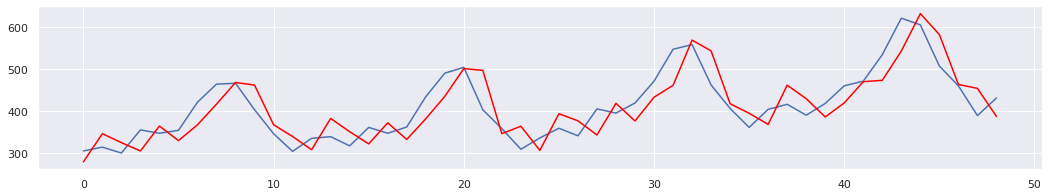

In [125]:
# plot forecasts against actual outcomes
plt.rc('figure', figsize=(18, 3))
plt.plot(test)
plt.plot(predictions, color='red')

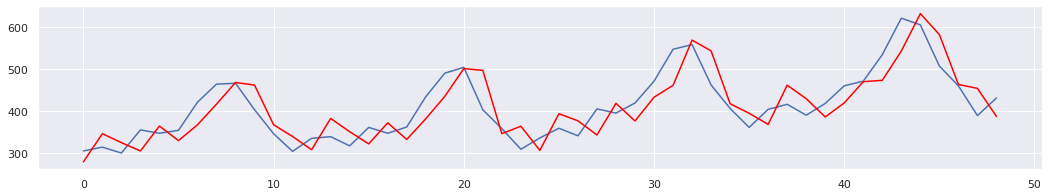

In [126]:
# zoom plot
plt.plot(test_y[-100:])
plt.plot(predictions[-100:], color='red')
plt.show()

Grid Search ARIMA Model Hyperparameters

In [127]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]

    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = np.sqrt(mean_squared_error(test, predictions))
    return rmse


In [128]:
# evaluate parameters
p = 3
d = 1
q = 0
order = (p, d, q)
evaluate_arima_model(s.values, order)

44.78200351388101

In [129]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))


In [130]:
import warnings
warnings.filterwarnings("ignore")

In [131]:
# evaluate parameters
p_values = [0, 1, 2]
d_values = [0, 1]
q_values = [0, 1]

evaluate_models(s.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=180.036
ARIMA(0, 0, 1) RMSE=97.759
ARIMA(0, 1, 0) RMSE=47.913
ARIMA(0, 1, 1) RMSE=45.258
ARIMA(1, 0, 0) RMSE=48.329
ARIMA(1, 0, 1) RMSE=45.622
ARIMA(1, 1, 0) RMSE=45.806
ARIMA(1, 1, 1) RMSE=45.794
ARIMA(2, 0, 0) RMSE=46.027
ARIMA(2, 0, 1) RMSE=45.155
ARIMA(2, 1, 0) RMSE=45.176
ARIMA(2, 1, 1) RMSE=39.140
Best ARIMA(2, 1, 1) RMSE=39.140



<h4>Rolling Forecast with Selected ARIMA Model: Walk Forward Validation</h4>

ARIMA(1, 1, 0) performed best and we select it for our final model.


In [132]:
# split into train and test sets
X = s.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = []

In [133]:
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))


In [134]:
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 45.806


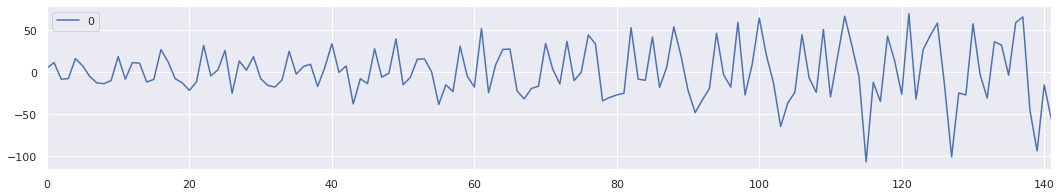

In [135]:
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

[(-2, 2)]

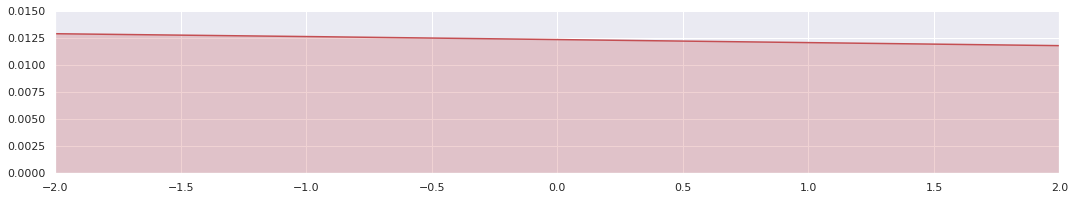

In [136]:


# density plot of residuals, using Seaborn kdeplot
sns.set(color_codes=True)
sns.kdeplot(np.hstack(residuals.values), shade=True, color="r").set(xlim=(-2, 2))



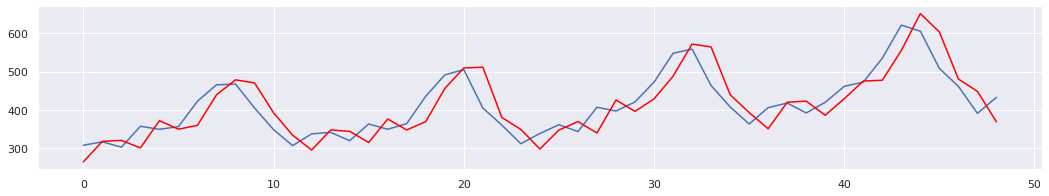

In [137]:
# plot forecasts against actual outcomes
plt.rc('figure', figsize=(18, 3))
plt.plot(test)
plt.plot(predictions, color='red')

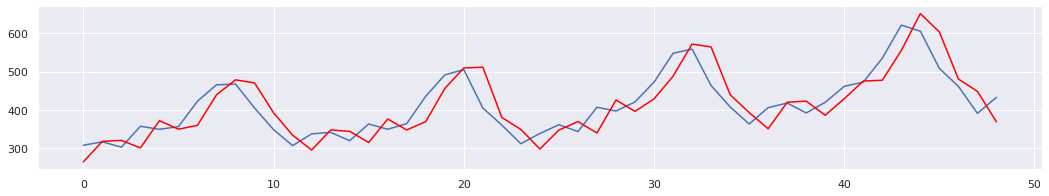

In [138]:
# zoom plot
plt.plot(test_y[-100:])
plt.plot(predictions[-100:], color='red')
plt.show()

Let's just quickly review which part of the time series we were evaluating.

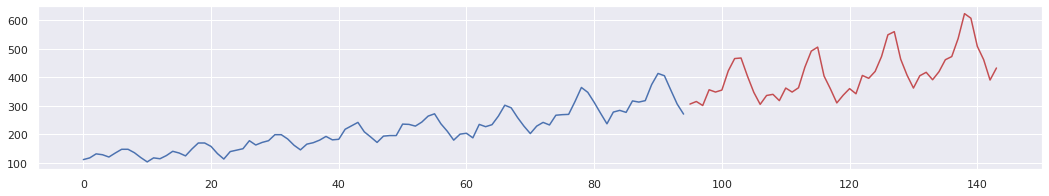

In [140]:
# plot train-test split of time series data
plt.plot(train)
plt.plot([None for i in train] + [x for x in test], color='r')